In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 1. Data loading and initial exploration

In [3]:
# Data loading
path = r'../data/raw/data_raw.csv'
alzheimer_df = pd.read_csv(path)

In [4]:
# Data dimensions and types 
print("data shape: ", alzheimer_df.shape)
print("data types:\n", alzheimer_df.dtypes)

data shape:  (329637, 14)
data types:
 Año               int64
Semana           object
Pag.              int64
Cuadro           object
No_01           float64
Entidad          object
No_02           float64
Padecimiento     object
Ax_001            int64
Ax_002           object
Ax_003           object
No_03           float64
Valor            object
No_04           float64
dtype: object


In [5]:
# Confirming structure
alzheimer_df.head()

,Año,Semana,Pag.,Cuadro,No_01,Entidad,No_02,Padecimiento,Ax_001,Ax_002,Ax_003,No_03,Valor,No_04
0,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,DepresiónCIE-10ª REV.F32,2014,0,Sem.,NaN,1,NaN
1,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,DepresiónCIE-10ª REV.F32,2014,Acum.,H,NaN,1,NaN
2,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,DepresiónCIE-10ª REV.F32,2014,Acum.,M,NaN,-,NaN
3,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,Enfermedad de Parkinson CIE-10ª REV. G20,2014,0,Sem.,NaN,-,NaN
4,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,Enfermedad de Parkinson CIE-10ª REV. G20,2014,Acum.,H,NaN,-,NaN


## 2. Preliminary cleaning

In [6]:
#Filtering only the rows about alzheimers disease
alzheimer_df = alzheimer_df[alzheimer_df["Padecimiento"].str.startswith("Enfermedad de Alzheimer", na=False)]

In [7]:
#cleaning innecesary columns
alzheimer_df = alzheimer_df.drop(["Pag.", "Cuadro ", "No_01", "No_02", "No_03", "No_04", "Ax_001", "Ax_002", "Padecimiento"], axis=1)

In [8]:
# replacing "-" by "0"
alzheimer_df["Valor"] = alzheimer_df["Valor"].replace("-", "0")

# converting to numeric data type
alzheimer_df["Valor"] = pd.to_numeric(alzheimer_df["Valor"], errors="coerce")

In [9]:
# Converting "Semana" to a numeric data type
alzheimer_df["Semana"] = alzheimer_df["Semana"].str.replace("sem", "", regex=False).astype(int)

In [10]:
# replacing Entidad name 
alzheimer_df["Entidad"] = alzheimer_df["Entidad"].replace("Distrito Federal", "Ciudad de México")

In [11]:
# Removing redundant data

# Removing rows with "Acum." in "Ax_003" column
alzheimer_df = alzheimer_df[alzheimer_df["Ax_003"] != "Acum."]

# Removing rows with "TOTAL" in "Entidad" column
alzheimer_df = alzheimer_df[alzheimer_df["Entidad"] != "TOTAL"]

In [12]:
# Missing values
nan_counts = alzheimer_df.isna().sum()
columnas_con_nan = nan_counts[nan_counts > 0]
columnas_con_nan_ordenadas = columnas_con_nan.sort_values(ascending=False)
print(columnas_con_nan_ordenadas)

Valor    1
dtype: int64


In [13]:
# Duplicated rows
alzheimer_df.duplicated().sum()

np.int64(0)

In [14]:
suma = alzheimer_df["Valor"].sum()
print(suma)

745043.0


In [15]:
alzheimer_df.head(20)

,Año,Semana,Entidad,Ax_003,Valor
6,2014,2,Aguascalientes,Sem.,0.0
7,2014,2,Aguascalientes,H,0.0
8,2014,2,Aguascalientes,M,0.0
15,2014,2,Baja California,Sem.,0.0
16,2014,2,Baja California,H,0.0
17,2014,2,Baja California,M,0.0
24,2014,2,Baja California Sur,Sem.,0.0
25,2014,2,Baja California Sur,H,0.0
26,2014,2,Baja California Sur,M,0.0
33,2014,2,Campeche,Sem.,0.0


## 3. Useful subset selection

In [16]:
# Pivot Ax_003 to get separate columns for each category
df_pivot = alzheimer_df.pivot_table(
    index=["Año", "Semana", "Entidad"],
    columns="Ax_003",
    values="Valor",
    aggfunc="first"
).reset_index()

df_pivot = df_pivot.rename(columns={
    "Sem.": "Casos_Semanal_Total",
    "H": "Casos_Acum_Hombres",
    "M": "Casos_Acum_Mujeres"
})

df_pivot.columns.name = None

df_subset = df_pivot.drop('Casos_Semanal_Total', axis=1)

df_subset.head()

,Año,Semana,Entidad,Casos_Acum_Hombres,Casos_Acum_Mujeres
0,2014,2,Aguascalientes,0.0,0.0
1,2014,2,Baja California,0.0,0.0
2,2014,2,Baja California Sur,0.0,0.0
3,2014,2,Campeche,0.0,0.0
4,2014,2,Chiapas,0.0,0.0


## 4. Consistency validation

In [17]:
# Sorting values for consistency checks
df_sorted = df_pivot.sort_values(["Entidad", "Año", "Semana"])

# Calculate week-to-week differences
df_sorted["Delta_H"] = df_sorted.groupby(["Entidad"])["Casos_Acum_Hombres"].diff()
df_sorted["Delta_M"] = df_sorted.groupby(["Entidad"])["Casos_Acum_Mujeres"].diff()

# Verify inconsistencies
df_inconsistencies = df_sorted[
    (df_sorted["Delta_H"] < 0) |
    (df_sorted["Delta_M"] < 0) |
    ((df_sorted["Casos_Semanal_Total"] > 0) &
     ((df_sorted["Delta_H"] + df_sorted["Delta_M"]) != df_sorted["Casos_Semanal_Total"]))
]
df_inconsistencies = df_inconsistencies[df_inconsistencies["Semana"] != 2]
print(f"Number of inconsistencies found: {len(df_inconsistencies)}")


Number of inconsistencies found: 547


In [18]:
df_inconsistencies.head()

,Año,Semana,Entidad,Casos_Acum_Hombres,Casos_Acum_Mujeres,Casos_Semanal_Total,Delta_H,Delta_M
3040,2015,44,Aguascalientes,3.0,9.0,0.0,0.0,-1.0
3936,2016,20,Aguascalientes,17.0,18.0,1.0,12.0,9.0
3968,2016,21,Aguascalientes,5.0,9.0,0.0,-12.0,-9.0
4000,2016,22,Aguascalientes,6.0,11.0,2.0,1.0,2.0
4352,2016,33,Aguascalientes,13.0,21.0,1.0,2.0,1.0


## 5. Univariate analysis

### - Distribution of cases per week throughout Mexico

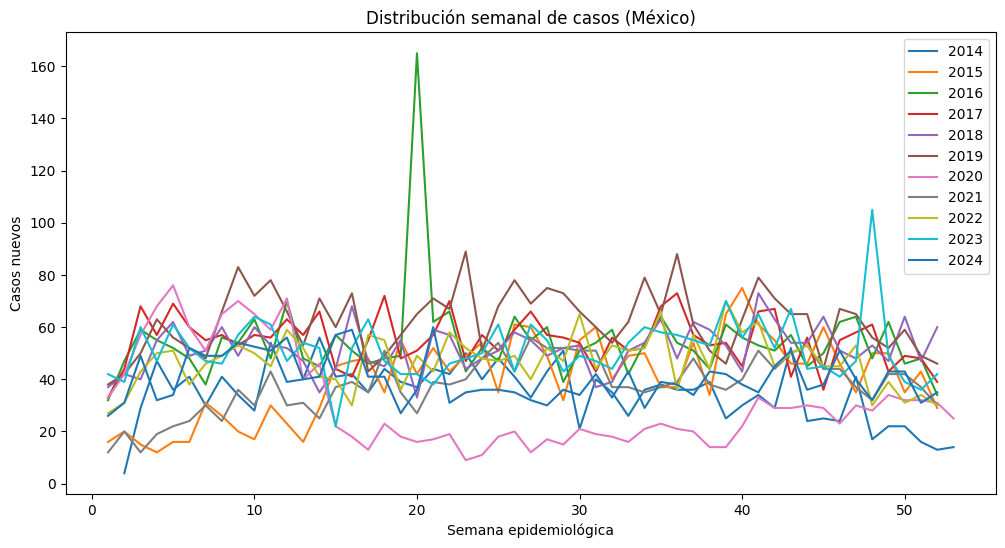

In [19]:
# Agrupar por año y semana, sumando todos los estados
semanal_mexico = df_pivot.groupby(["Año", "Semana"])["Casos_Semanal_Total"].sum().reset_index()

# Graficar todas las curvas, un color por año
plt.figure(figsize=(12,6))
for año, grupo in semanal_mexico.groupby("Año"):
    plt.plot(grupo["Semana"], grupo["Casos_Semanal_Total"], label=str(año))

plt.title("Distribución semanal de casos (México)")
plt.xlabel("Semana epidemiológica")
plt.ylabel("Casos nuevos")
plt.legend()
plt.show()

### - Annual distribution of cases

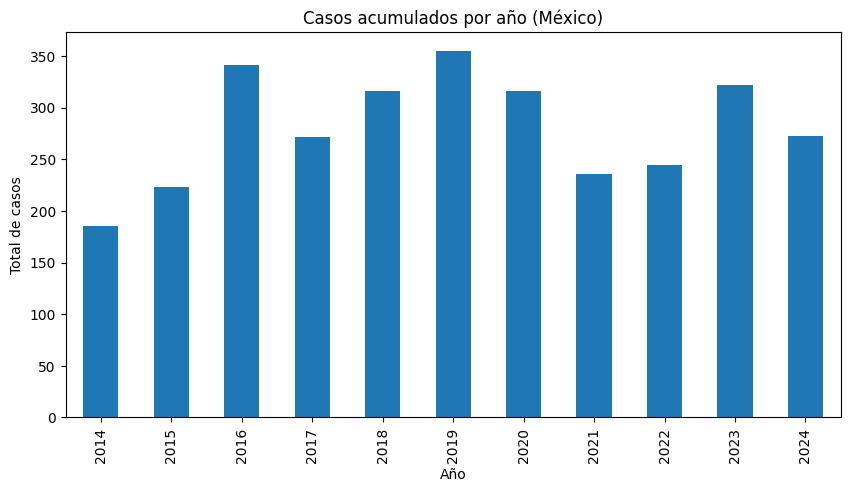

In [20]:
# Tomamos el acumulado final (última semana) de cada año y entidad
anual_mexico = df_subset.groupby(["Año"])[["Casos_Acum_Hombres", "Casos_Acum_Mujeres"]].max().sum(axis=1)

# Gráfico
anual_mexico.plot(kind="bar", figsize=(10,5))
plt.title("Casos acumulados por año (México)")
plt.xlabel("Año")
plt.ylabel("Total de casos")
plt.show()

### - Average and variability by state

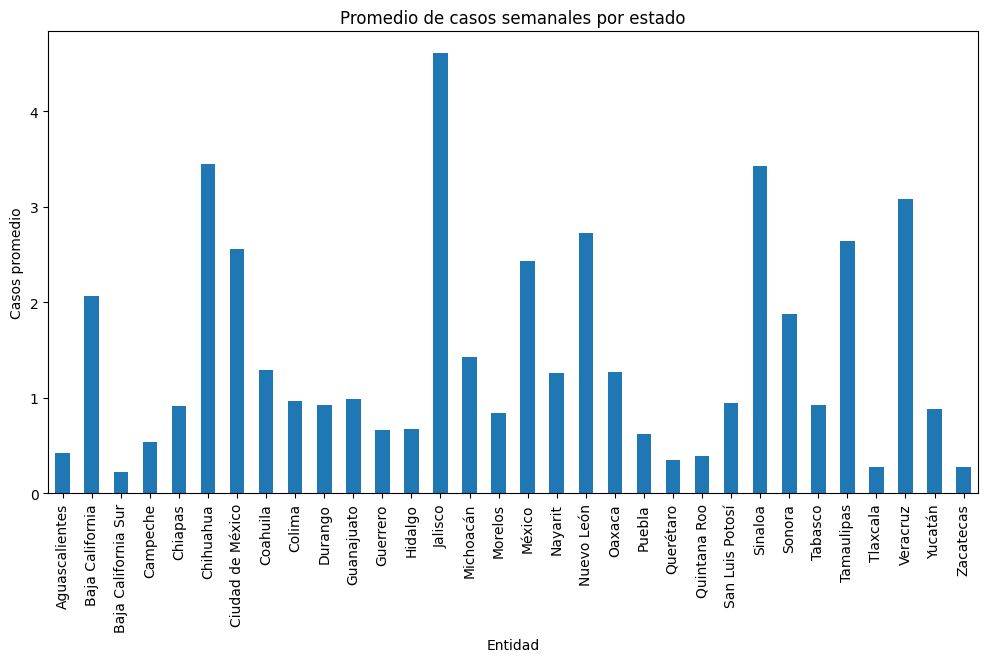

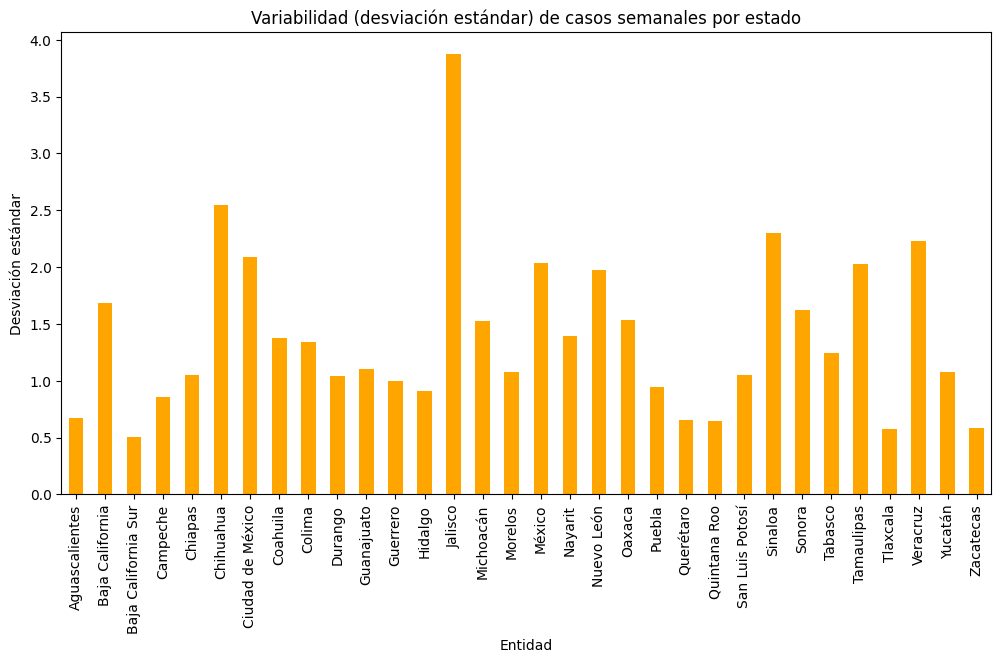

In [21]:
# Promedio y std de casos semanales por estado
estadisticas_estado = df_pivot.groupby("Entidad")["Casos_Semanal_Total"].agg(["mean","std"]).reset_index()

# Promedio
estadisticas_estado.plot(x="Entidad", y="mean", kind="bar", figsize=(12,6), legend=False)
plt.title("Promedio de casos semanales por estado")
plt.ylabel("Casos promedio")
plt.xticks(rotation=90)
plt.show()

# Variabilidad
estadisticas_estado.plot(x="Entidad", y="std", kind="bar", figsize=(12,6), legend=False, color="orange")
plt.title("Variabilidad (desviación estándar) de casos semanales por estado")
plt.ylabel("Desviación estándar")
plt.xticks(rotation=90)
plt.show()

## 6. Bivariate Analysis

### - Men vs Women

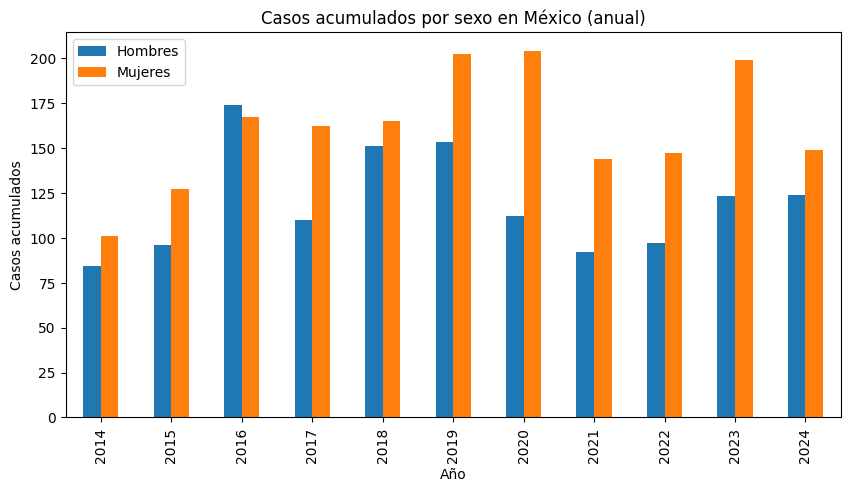

In [22]:
# Total acumulado por año, separados Hombres/Mujeres
anual_sexo = df_subset.groupby("Año")[["Casos_Acum_Hombres", "Casos_Acum_Mujeres"]].max()

# Gráfico comparativo
anual_sexo.plot(kind="bar", figsize=(10,5))
plt.title("Casos acumulados por sexo en México (anual)")
plt.xlabel("Año")
plt.ylabel("Casos acumulados")
plt.legend(["Hombres", "Mujeres"])
plt.show()

### - Time series by entity

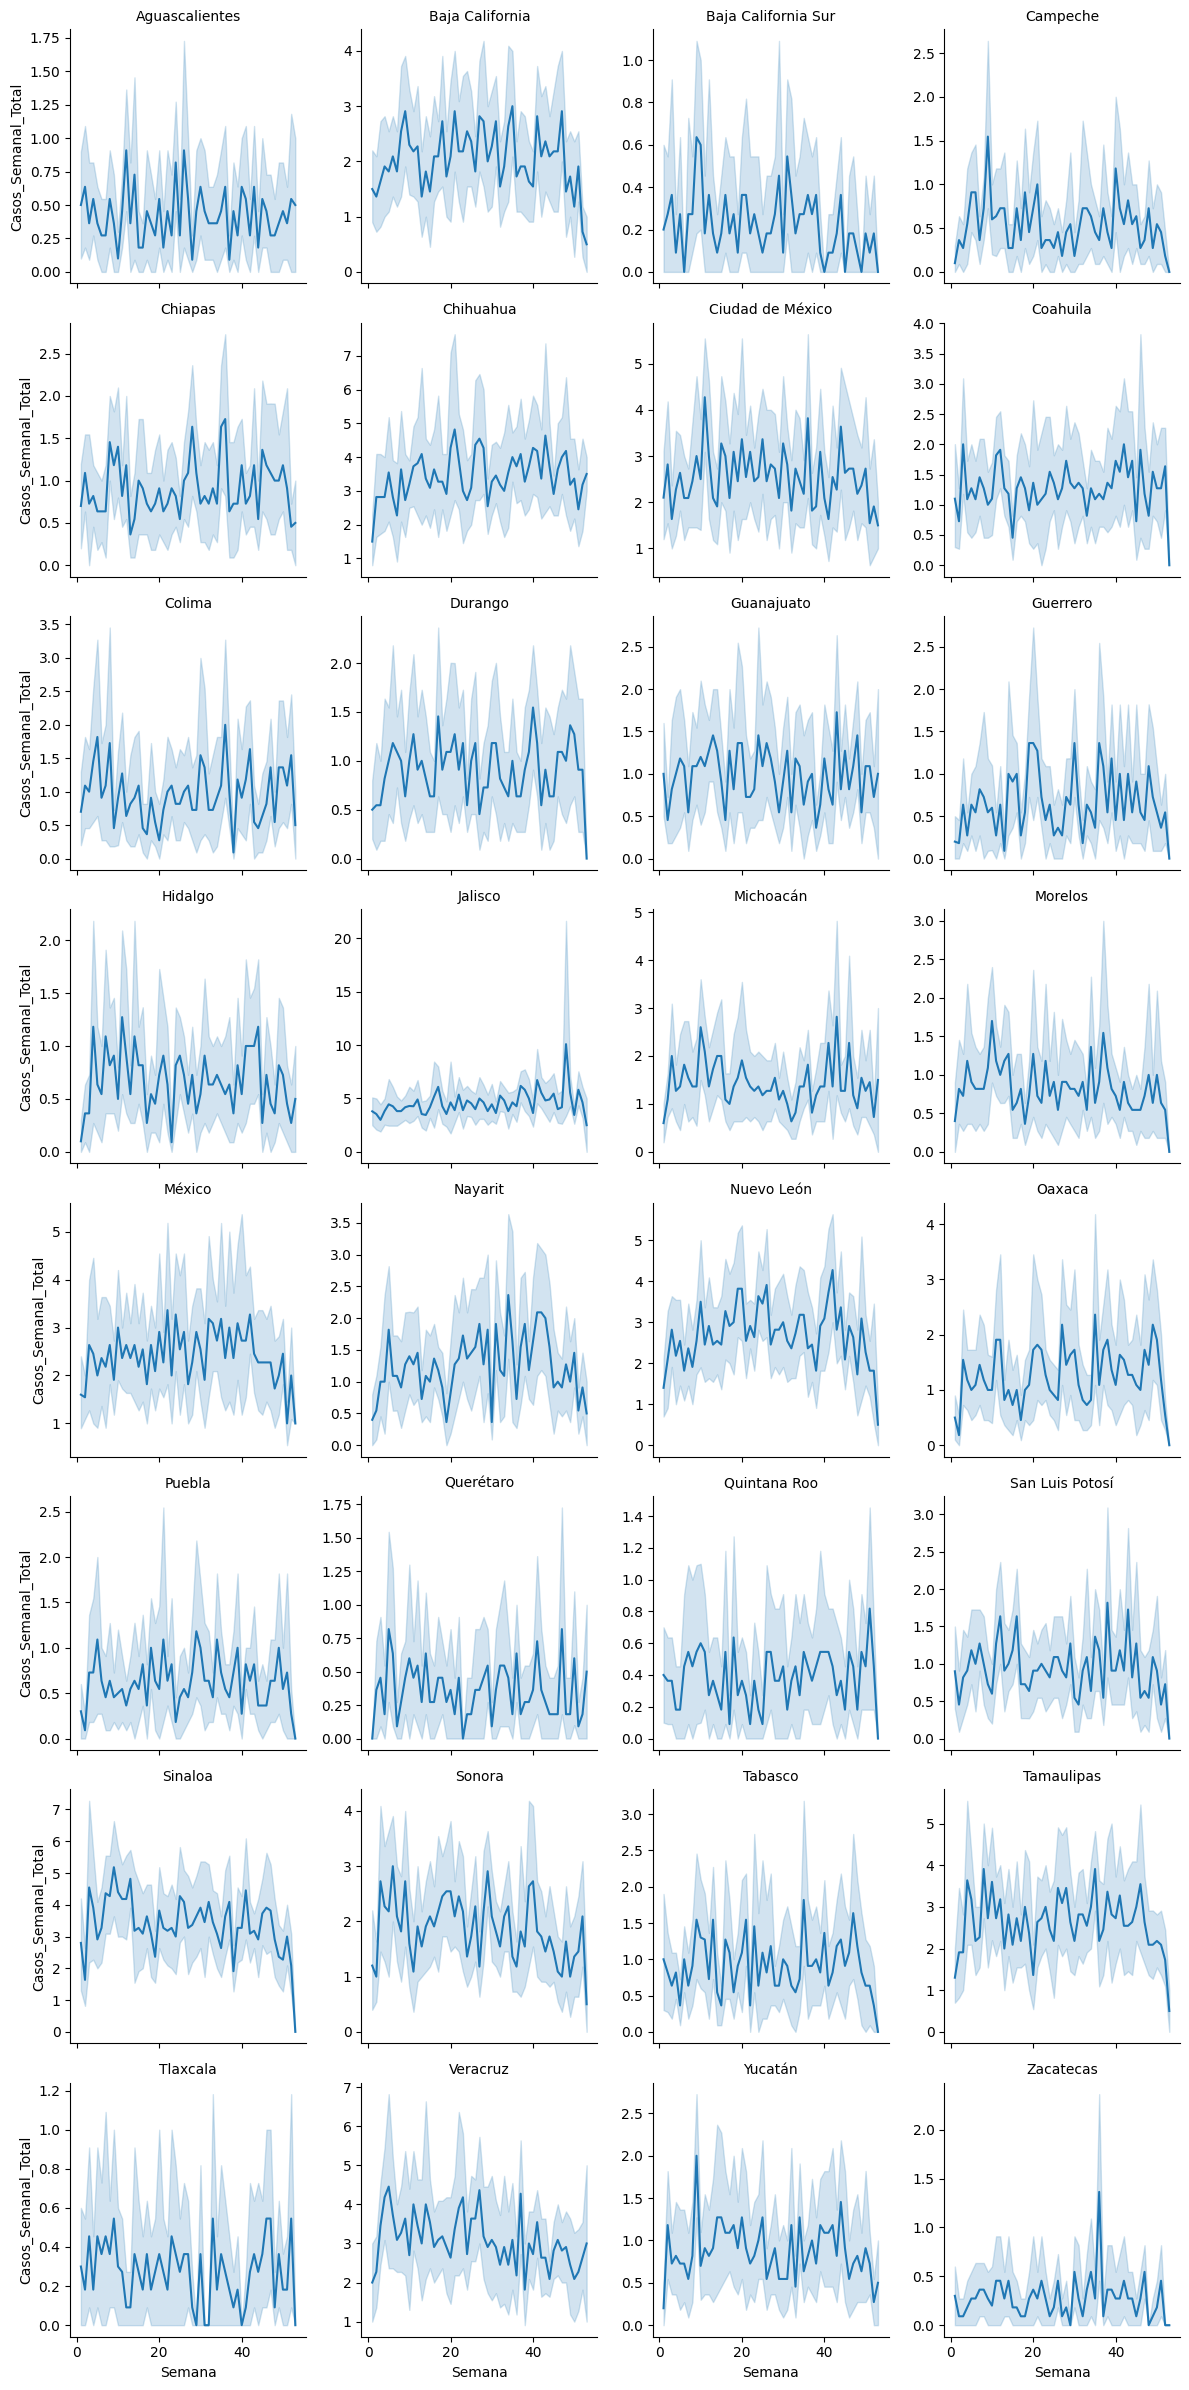

In [23]:
g = sns.FacetGrid(df_pivot, col="Entidad", col_wrap=4, height=3, sharey=False)
g.map_dataframe(sns.lineplot, x="Semana", y="Casos_Semanal_Total")
g.set_titles("{col_name}")
plt.show()

### - Annual and seasonal trends

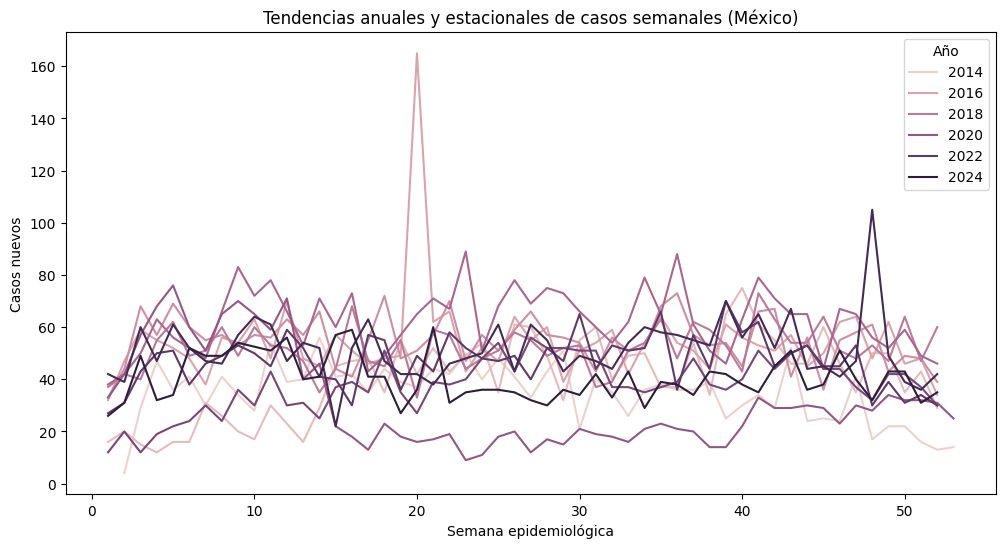

In [24]:
# Promedio de casos semanales por año y semana (todo México)
tendencias = df_pivot.groupby(["Año","Semana"])["Casos_Semanal_Total"].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=tendencias, x="Semana", y="Casos_Semanal_Total", hue="Año")
plt.title("Tendencias anuales y estacionales de casos semanales (México)")
plt.xlabel("Semana epidemiológica")
plt.ylabel("Casos nuevos")
plt.show()

## 7. Exploration focused on time series

In [25]:
# crear el índice temporal ISO (YYYY-WXX-D). Usamos '-WXX-1' para el lunes de la semana.
df_nacional_semanal = semanal_mexico
df_nacional_semanal['Fecha_ISO'] = df_nacional_semanal['Año'].astype(str) + '-W' + df_nacional_semanal['Semana'].astype(str).str.zfill(2) + '-1'
df_nacional_semanal['Fecha'] = pd.to_datetime(df_nacional_semanal['Fecha_ISO'], format='%Y-W%W-%w', errors='coerce')
df_nacional_semanal = df_nacional_semanal.set_index('Fecha').sort_index()
df_nacional_semanal.head(10)

,Año,Semana,Casos_Semanal_Total,Fecha_ISO
Fecha,,,,
2014-01-13,2014,2,4.0,2014-W02-1
2014-01-20,2014,3,29.0,2014-W03-1
2014-01-27,2014,4,47.0,2014-W04-1
2014-02-03,2014,5,36.0,2014-W05-1
2014-02-10,2014,6,41.0,2014-W06-1
2014-02-17,2014,7,30.0,2014-W07-1
2014-02-24,2014,8,41.0,2014-W08-1
2014-03-03,2014,9,34.0,2014-W09-1
2014-03-10,2014,10,28.0,2014-W10-1


In [26]:
# objeto Serie de Tiempo base
ts_nacional = df_nacional_semanal['Casos_Semanal_Total']

# se valida la existencia de fechas duplicadas en el índice
duplicates = ts_nacional.index[ts_nacional.index.duplicated()]
duplicates

DatetimeIndex(['2015-01-05', '2021-01-04'], dtype='datetime64[ns]', name='Fecha', freq=None)

In [27]:
# se observa que los duplicados son por inconsistencias en el número total de las semanas del año anterior inmediato
# se opta por hacer un collapse de fechas duplicadas sumando sus valores
ts_nacional = ts_nacional.groupby(ts_nacional.index).sum()
ts_nacional

Fecha
2014-01-13     4.0
2014-01-20    29.0
2014-01-27    47.0
2014-02-03    36.0
2014-02-10    41.0
              ... 
2024-11-25    32.0
2024-12-02    43.0
2024-12-09    43.0
2024-12-16    31.0
2024-12-23    35.0
Name: Casos_Semanal_Total, Length: 570, dtype: float64

### - Reindex to a full weekly frequency ('W-MON') and fill missing weeks with 0

In [28]:
# esto asegura una serie de tiempo continua, indispensable para el análisis de ST.
idx_full = pd.date_range(start=ts_nacional.index.min(), end=ts_nacional.index.max(), freq='W-MON')
ts_full = ts_nacional.reindex(idx_full, fill_value=0) # serie de tiempo completa
ts_full_df = ts_full.to_frame(name='Casos_Nuevos')
ts_full_df['Año'] = ts_full_df.index.year

print(f"Número de semanas en la serie original (con reportes): {len(ts_nacional)}")
print(f"Número de semanas en la serie reindexada (continua): {len(ts_full)}")
print(f"Semanas faltantes imputadas con 0: {len(ts_full) - len(ts_nacional)}")

Número de semanas en la serie original (con reportes): 570
Número de semanas en la serie reindexada (continua): 572
Semanas faltantes imputadas con 0: 2


### - Boxplots

<Figure size 1200x600 with 0 Axes>

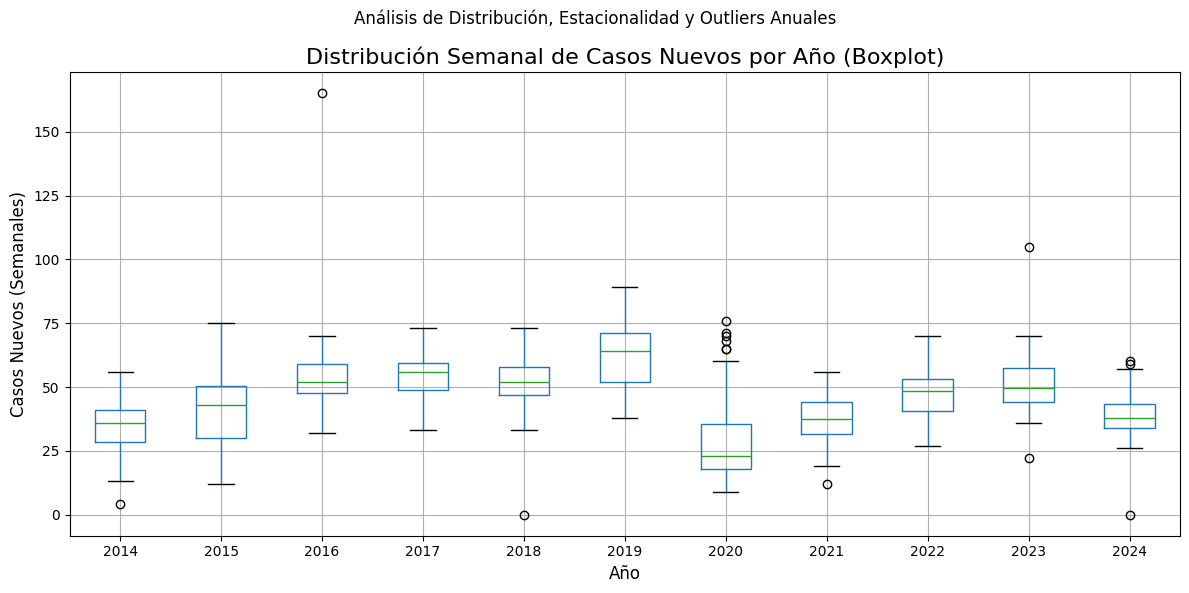

In [29]:
plt.figure(figsize=(12, 6))

# el boxplot agrupado por año muestra la dispersión y los outliers por período anual
ts_full_df.boxplot(column='Casos_Nuevos', by='Año', figsize=(12, 6), grid=True)
plt.title('Distribución Semanal de Casos Nuevos por Año (Boxplot)', fontsize=16)
plt.suptitle('Análisis de Distribución, Estacionalidad y Outliers Anuales')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Casos Nuevos (Semanales)', fontsize=12)
plt.tight_layout()
plt.show()

### - Outlier detection (2-sigma Moving Window)

In [30]:
# se calcula la media y desviación estándar móvil usando una ventana de 12 semanas (aprox. 3 meses).
ts_full_df['Media_Móvil'] = ts_full_df['Casos_Nuevos'].rolling(window=12, center=True).mean()
ts_full_df['Desv_Est_Móvil'] = ts_full_df['Casos_Nuevos'].rolling(window=12, center=True).std()

# se define el límite superior de 2 desviaciones estándar (2-sigma) para detectar puntos anómalos.
ts_full_df['Limite_Superior'] = ts_full_df['Media_Móvil'] + (2 * ts_full_df['Desv_Est_Móvil'])

In [31]:
# identificar los puntos donde el valor real supera el límite superior móvil
outliers = ts_full_df[ts_full_df['Casos_Nuevos'] > ts_full_df['Limite_Superior']]
print(f"Se detectaron {len(outliers)} puntos atípicos (2-sigma sobre media móvil de 12 semanas).")
print("Detalle de Atípicos (Casos Nuevos vs. Límite Superior Móvil):")
print(outliers[['Casos_Nuevos', 'Limite_Superior']].to_markdown(numalign="left", stralign="left"))

Se detectaron 5 puntos atípicos (2-sigma sobre media móvil de 12 semanas).
Detalle de Atípicos (Casos Nuevos vs. Límite Superior Móvil):
|                     | Casos_Nuevos   | Limite_Superior   |
|:--------------------|:---------------|:------------------|
| 2014-10-27 00:00:00 | 52             | 50.485            |
| 2016-03-21 00:00:00 | 70             | 69.2679           |
| 2016-05-16 00:00:00 | 165            | 127.939           |
| 2021-05-03 00:00:00 | 51             | 49.4255           |
| 2023-11-27 00:00:00 | 105            | 89.5207           |


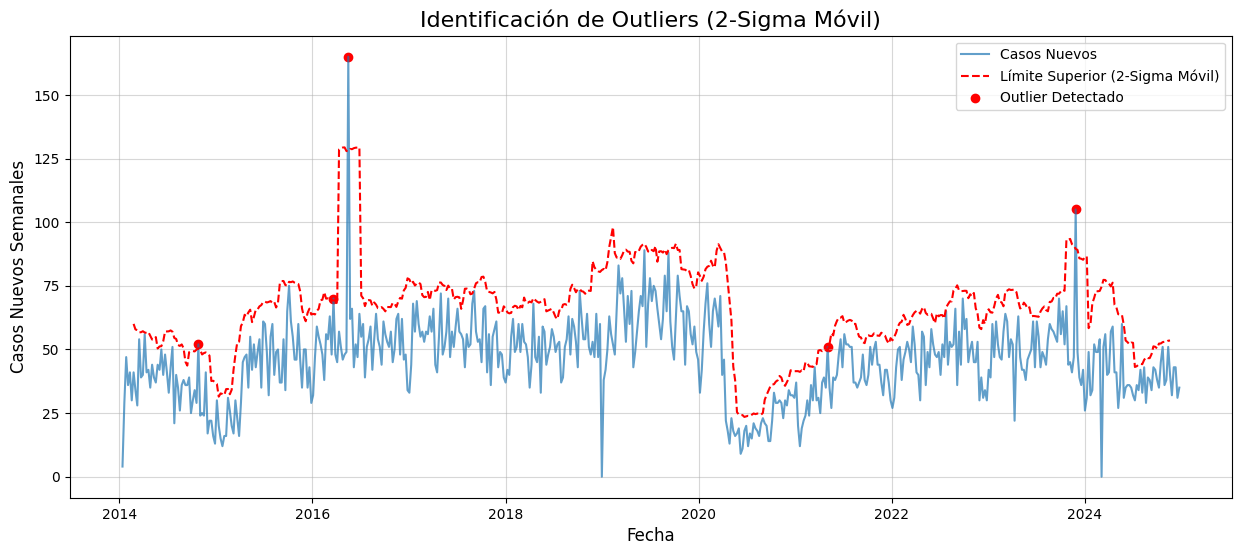

In [32]:
# visualización de la detección de Outliers
plt.figure(figsize=(15, 6))
plt.plot(ts_full_df.index, ts_full_df['Casos_Nuevos'], label='Casos Nuevos', alpha=0.7)
plt.plot(ts_full_df.index, ts_full_df['Limite_Superior'], label='Límite Superior (2-Sigma Móvil)', color='red', linestyle='--')
plt.scatter(outliers.index, outliers['Casos_Nuevos'], color='red', marker='o', label='Outlier Detectado')
plt.title('Identificación de Outliers (2-Sigma Móvil)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Casos Nuevos Semanales', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

### - Time Series Decomposition

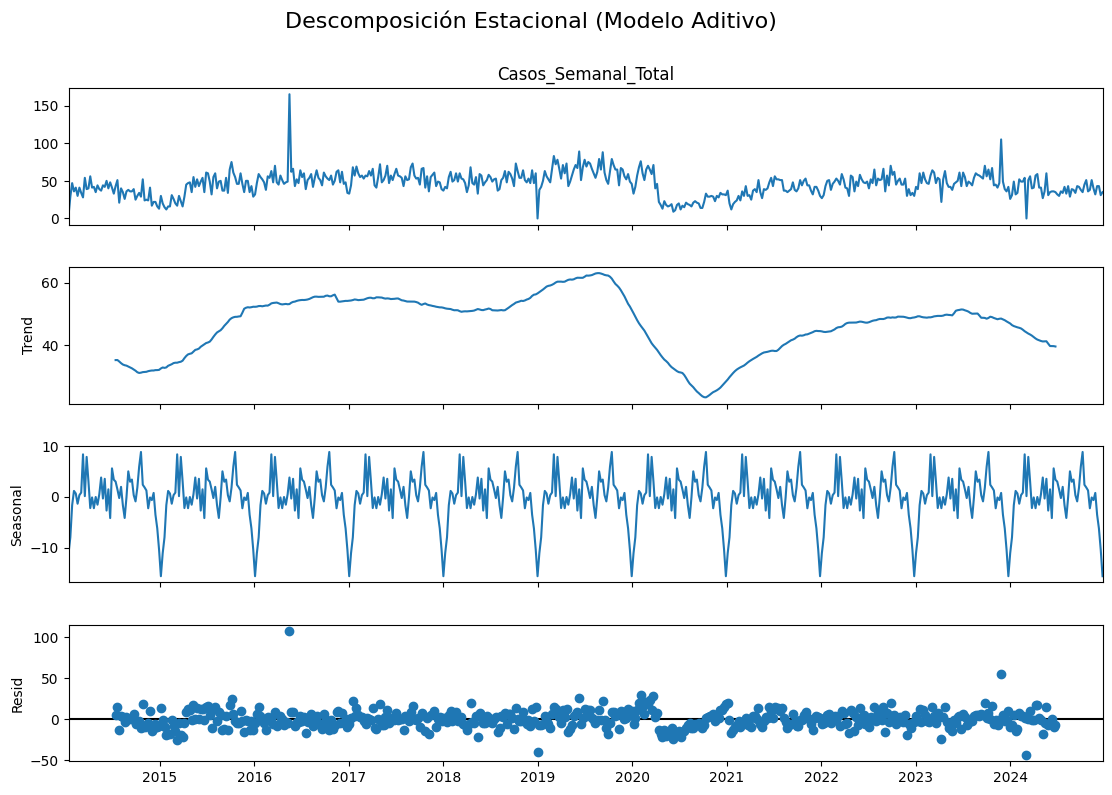

In [33]:
# se utiliza el modelo Aditivo porque las fluctuaciones estacionales no crecen con la tendencia.
# el periodo es 52 (semanas) ya que los datos son semanales.
decomposition = seasonal_decompose(ts_full, model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Descomposición Estacional (Modelo Aditivo)', y=1.02, fontsize=16)
plt.show()

### - Stationarity Tests (ADF and KPSS)

In [34]:
# función auxiliar para pruebas de estacionaridad
def check_stationarity(timeseries):
    # test de Dickey-Fuller Aumentado (ADF). Hipótesis Nula (H0): La serie NO es estacionaria.
    print('Resultados del Test de Dickey-Fuller Aumentado (ADF):')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    is_stationary_adf = "NO ES ESTACIONARIA (Falla al rechazar H0)" if dftest[1] > 0.05 else "ES ESTACIONARIA (Rechaza H0)"
    
    print(dfoutput.to_markdown(numalign="left", stralign="left"))
    print(f"Conclusión (p-value {dftest[1]:.4f}): {is_stationary_adf}\n")

    # test KPSS. Hipótesis Nula (H0): La serie ES estacionaria.
    print('Resultados del Test KPSS:')
    kpsstest = kpss(timeseries, regression='c', nlags='auto') # 'c' para estacionariedad de nivel
    kpss_output = pd.Series(kpsstest[0:3], index=['KPSS Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value

    is_stationary_kpss = "ES ESTACIONARIA (No rechaza H0)" if kpsstest[1] > 0.05 else "NO ES ESTACIONARIA (Rechaza H0)"

    print(kpss_output.to_markdown(numalign="left", stralign="left"))
    print(f"Conclusión (p-value {kpsstest[1]:.4f}): {is_stationary_kpss}")

In [35]:
# aplicar las pruebas sobre la serie de tiempo completa ts_full
check_stationarity(ts_full)

Resultados del Test de Dickey-Fuller Aumentado (ADF):
|                      | 0          |
|:---------------------|:-----------|
| ADF Statistic        | -3.91147   |
| p-value              | 0.00195202 |
| Lags Used            | 5          |
| No. of Obs           | 566        |
| Critical Value (1%)  | -3.44196   |
| Critical Value (5%)  | -2.86666   |
| Critical Value (10%) | -2.5695    |
Conclusión (p-value 0.0020): ES ESTACIONARIA (Rechaza H0)

Resultados del Test KPSS:
|                       | 0        |
|:----------------------|:---------|
| KPSS Statistic        | 0.247815 |
| p-value               | 0.1      |
| Lags Used             | 14       |
| Critical Value (10%)  | 0.347    |
| Critical Value (5%)   | 0.463    |
| Critical Value (2.5%) | 0.574    |
| Critical Value (1%)   | 0.739    |
Conclusión (p-value 0.1000): ES ESTACIONARIA (No rechaza H0)


C:\Users\aaron\AppData\Local\Temp\ipykernel_20208\1337082908.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags='auto') # 'c' para estacionariedad de nivel


##### El "warning" visto confirma que la evidencia a favor de la hipótesis nula (H ES estacionaria) es tan fuerte que el estadístico está muy lejos de la zona de rechazo.

### - Autocorrelation Plots (ACF and PACF)

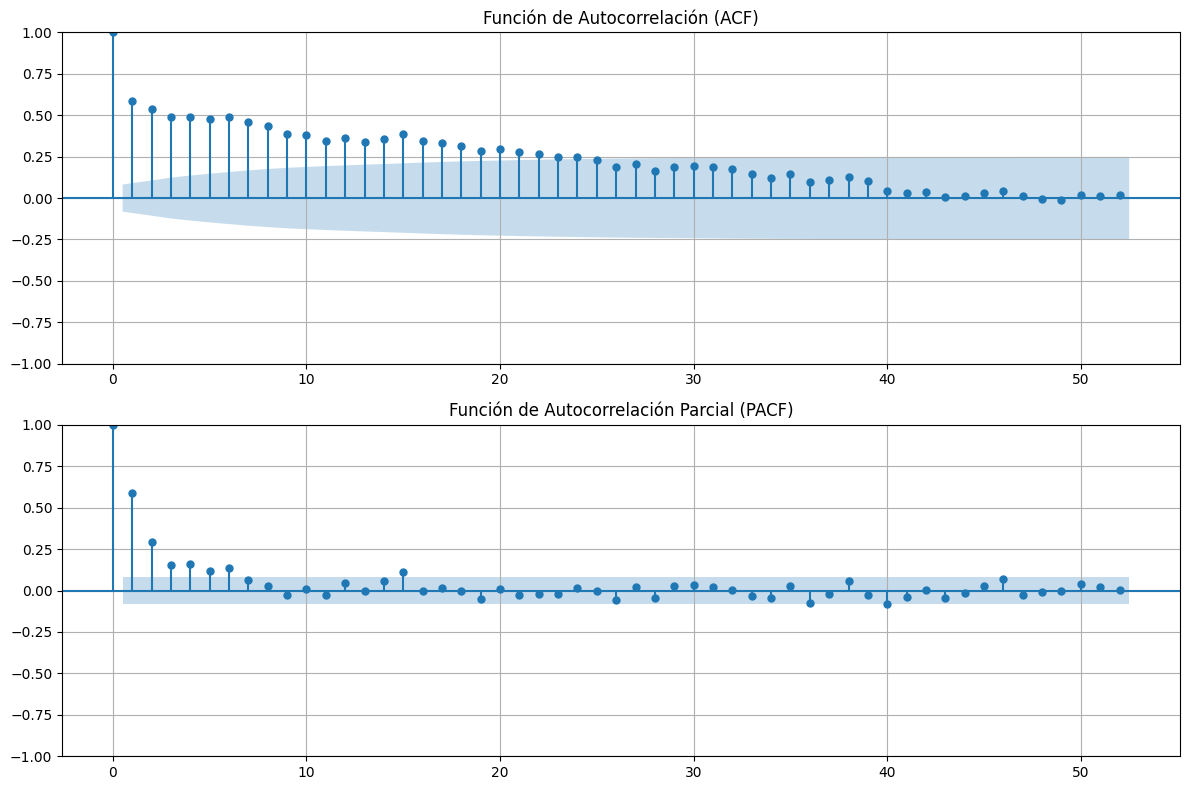

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# plot ACF: Muestra la correlación total con sus rezagos (lags).
# se usan 52 lags para capturar la estacionalidad anual.
plot_acf(ts_full, lags=52, ax=axes[0], title='Función de Autocorrelación (ACF)')
axes[0].grid(True)

# plot PACF: Muestra la correlación directa con cada rezago.
plot_pacf(ts_full, lags=52, ax=axes[1], title='Función de Autocorrelación Parcial (PACF)')
axes[1].grid(True)

plt.tight_layout()
plt.show()